In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score

In [2]:
# === Load and Normalize Dataset ===
data = pd.read_csv("D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv")
X = data.values

# Optional: check shape
print("Original data shape:", data.shape)

Original data shape: (500, 3736)


In [3]:
# === Standar Scaler ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# === Split Dataset ===
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [5]:
# === Apply PCA to Reduce Noise ===
pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [6]:
# === Convert to Tensors ===
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)

In [7]:
# Create DataLoader for training and testing 
batch_size = 16
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

In [8]:
print("Training tensor shape:", X_train_tensor.shape)
print("Test tensor shape:", X_test_tensor.shape)

Training tensor shape: torch.Size([400, 19])
Test tensor shape: torch.Size([100, 19])


In [9]:
# === Define Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
# === Training Setup ===
input_dim = X_train_pca.shape[1]
encoding_dim = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

Epoch [1000/10000], Train Loss: 0.0350, Val Loss: 0.1092
Epoch [2000/10000], Train Loss: 0.0033, Val Loss: 0.0881
Epoch [3000/10000], Train Loss: 0.0023, Val Loss: 0.0881
Epoch [4000/10000], Train Loss: 0.0073, Val Loss: 0.0946
Epoch [5000/10000], Train Loss: 0.0175, Val Loss: 0.1006
Epoch [6000/10000], Train Loss: 0.0074, Val Loss: 0.1037
Epoch [7000/10000], Train Loss: 0.0085, Val Loss: 0.0918
Epoch [8000/10000], Train Loss: 0.0203, Val Loss: 0.1024
Epoch [9000/10000], Train Loss: 0.0277, Val Loss: 0.1105
Epoch [10000/10000], Train Loss: 0.0037, Val Loss: 0.0876


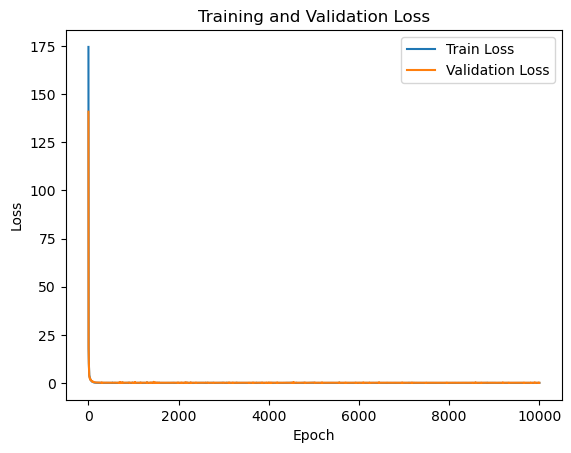

In [11]:
# === Training Loop ===
num_epochs = 10000
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs = batch.to(device)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch.to(device)
            _, outputs = model(inputs)
            val_loss += criterion(outputs, inputs).item()
    val_losses.append(val_loss / len(test_loader))

    # === Print Progress ===
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# === Plot Loss Curves ===
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# === Generate Synthetic Data ===
model.eval()
n_samples = 500
latent_dim = encoding_dim

latent_samples = torch.randn(n_samples, latent_dim).to(device)
with torch.no_grad():
    synthetic_decoded = model.decoder(latent_samples)

synthetic_decoded_np = synthetic_decoded.cpu().numpy()
synthetic_original_space = pca.inverse_transform(synthetic_decoded_np)
synthetic_data = scaler.inverse_transform(synthetic_original_space)

print("Synthetic data shape:", synthetic_data.shape)

Synthetic data shape: (500, 3736)


In [13]:
# Reload real data to get column names
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')

# Create a DataFrame for the synthetic data with correct columns
synthetic_df = pd.DataFrame(synthetic_data, columns=real_data.columns)

# Save to CSV
synthetic_df.to_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_SVM.csv', index=False)

print("✅ 500 synthetic samples generated and saved successfully!")

✅ 500 synthetic samples generated and saved successfully!


In [14]:
print("X_train shape:", X_train.shape)
print("synthetic_data shape:", synthetic_data.shape)
print("Total elements in X_train:", X_train.size)
print("Total elements in synthetic_data:", synthetic_data.size)

X_train shape: (400, 3736)
synthetic_data shape: (500, 3736)
Total elements in X_train: 1494400
Total elements in synthetic_data: 1868000


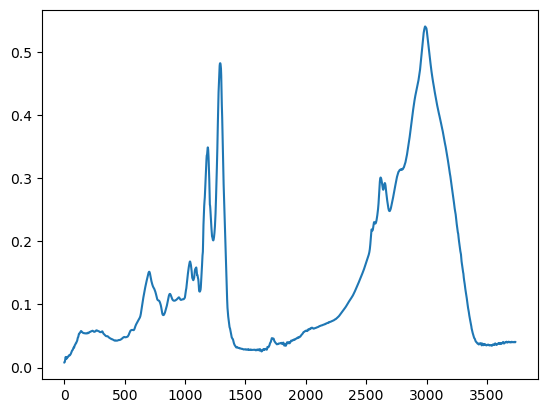

In [15]:
plt.plot(synthetic_data[20,:])

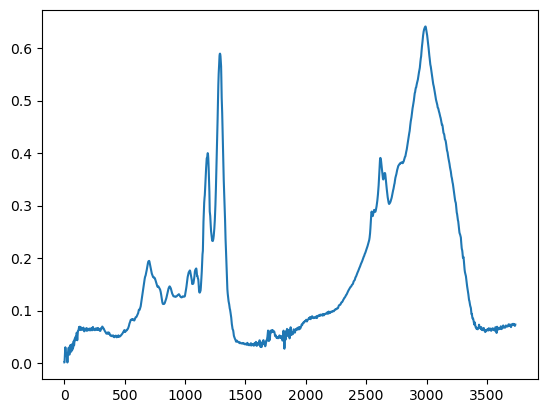

In [16]:
plt.plot(X[20,:])

In [17]:
np.shape(synthetic_data)

(500, 3736)

In [18]:
np.shape(X_train)

(400, 3736)

In [19]:
Y = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_SVM.csv')  

In [20]:
print (Y)

     Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  \
0         0.015236       0.014044       0.012580       0.011219   
1         0.015258       0.015114       0.014445       0.013633   
2         0.018012       0.017567       0.016307       0.014778   
3         0.016497       0.015980       0.015095       0.014194   
4         0.011148       0.012882       0.014374       0.015376   
..             ...            ...            ...            ...   
495       0.010061       0.010207       0.010417       0.010676   
496       0.013573       0.012726       0.011523       0.010410   
497       0.010503       0.011149       0.011419       0.011408   
498       0.009715       0.009750       0.009911       0.010151   
499       0.008663       0.010175       0.011810       0.013236   

     Wavelenght403  Wavelenght404  Wavelenght405  Wavelenght406  \
0         0.010136       0.009484       0.009440       0.010122   
1         0.012871       0.012262       0.011918       0.0119

In [21]:
data_fake = Y

In [22]:
data_fake.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.015236,0.014044,0.012580,0.011219,0.010136,0.009484,0.009440,0.010122,0.011464,0.013167,...,0.040483,0.040428,0.040407,0.040389,0.040329,0.040207,0.040054,0.039929,0.039884,0.040326
1,0.015258,0.015114,0.014445,0.013633,0.012871,0.012262,0.011918,0.011978,0.012542,0.013571,...,0.040650,0.040617,0.040626,0.040652,0.040654,0.040607,0.040528,0.040454,0.040415,0.040803
2,0.018012,0.017567,0.016307,0.014778,0.013322,0.012209,0.011703,0.012014,0.013166,0.014920,...,0.040944,0.040918,0.040923,0.040902,0.040808,0.040645,0.040475,0.040377,0.040394,0.040991
3,0.016497,0.015980,0.015095,0.014194,0.013498,0.013143,0.013203,0.013669,0.014422,0.015246,...,0.042159,0.042111,0.042097,0.042106,0.042099,0.042050,0.041967,0.041893,0.041872,0.042232
4,0.011148,0.012882,0.014374,0.015376,0.015806,0.015733,0.015373,0.015018,0.014904,0.015083,...,0.040938,0.040817,0.040661,0.040471,0.040244,0.040001,0.039798,0.039700,0.039745,0.040292


In [23]:
pip install --upgrade table_evaluator

Note: you may need to restart the kernel to use updated packages.


In [24]:
data_fake.shape

(500, 3736)

In [25]:
from table_evaluator import load_data, TableEvaluator

In [26]:
real, fake = load_data('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv', 'C:\\Users\\Ahmed\\Final\\synthetic_data_AE_SVM.csv')

In [27]:
real.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.002788,0.002679,0.002590,0.002397,0.002003,0.001440,0.001000,0.001180,0.002424,0.004826,...,0.055228,0.055092,0.054975,0.054888,0.054804,0.054691,0.054528,0.054321,0.054095,0.055661
1,0.011223,0.008644,0.005475,0.002793,0.001204,0.001000,0.002254,0.004759,0.007979,0.011209,...,0.061770,0.061952,0.062080,0.062084,0.061915,0.061576,0.061120,0.060638,0.060233,0.061807
2,0.008241,0.005308,0.002601,0.001042,0.001000,0.002507,0.005380,0.009190,0.013286,0.016967,...,0.074086,0.074106,0.074020,0.073812,0.073489,0.073087,0.072667,0.072293,0.072012,0.073635
3,0.004690,0.002150,0.001000,0.001314,0.002725,0.004786,0.006996,0.008779,0.009587,0.009128,...,0.048002,0.047823,0.047553,0.047284,0.047106,0.047079,0.047209,0.047450,0.047716,0.048322
4,-0.000024,0.001000,0.001965,0.002710,0.003198,0.003527,0.003874,0.004343,0.004843,0.005093,...,0.028844,0.028710,0.028535,0.028377,0.028270,0.028223,0.028226,0.028253,0.028278,0.028715


In [28]:
fake.head()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
0,0.015236,0.014044,0.012580,0.011219,0.010136,0.009484,0.009440,0.010122,0.011464,0.013167,...,0.040483,0.040428,0.040407,0.040389,0.040329,0.040207,0.040054,0.039929,0.039884,0.040326
1,0.015258,0.015114,0.014445,0.013633,0.012871,0.012262,0.011918,0.011978,0.012542,0.013571,...,0.040650,0.040617,0.040626,0.040652,0.040654,0.040607,0.040528,0.040454,0.040415,0.040803
2,0.018012,0.017567,0.016307,0.014778,0.013322,0.012209,0.011703,0.012014,0.013166,0.014920,...,0.040944,0.040918,0.040923,0.040902,0.040808,0.040645,0.040475,0.040377,0.040394,0.040991
3,0.016497,0.015980,0.015095,0.014194,0.013498,0.013143,0.013203,0.013669,0.014422,0.015246,...,0.042159,0.042111,0.042097,0.042106,0.042099,0.042050,0.041967,0.041893,0.041872,0.042232
4,0.011148,0.012882,0.014374,0.015376,0.015806,0.015733,0.015373,0.015018,0.014904,0.015083,...,0.040938,0.040817,0.040661,0.040471,0.040244,0.040001,0.039798,0.039700,0.039745,0.040292


In [29]:
# Apply the classifier

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)

# === Shuffle the data ===
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_7316\3995599451.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fake['label'] = 1  # Synthetic


In [30]:
# === Set up Support Vector Machine Classifier ===
clf = SVC(kernel='rbf', probability=False, random_state=42)
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

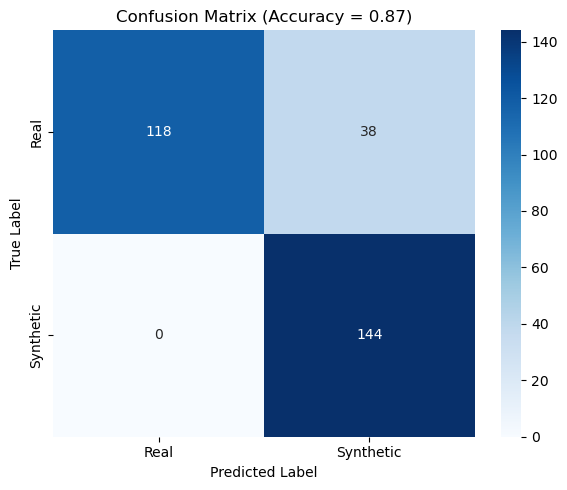

Accuracy:  0.8733
Precision: 0.7912
Recall:    1.0000
F1 Score:  0.8834


In [31]:
# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f})")
plt.tight_layout()
plt.show()

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [33]:
# 10-fold cross validation 

# === Label datasets ===
real['label'] = 0  # Real
fake['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real, fake], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Set up SVM Classifier and Cross-Validation ===
classifier = SVC(kernel='rbf', random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Cross-validated predictions ===
y_pred_class = cross_val_predict(classifier, X, y, cv=cv)

# === Compute metrics ===
accuracy = accuracy_score(y, y_pred_class)
precision = precision_score(y, y_pred_class)
recall = recall_score(y, y_pred_class)
f1 = f1_score(y, y_pred_class)
conf_matrix = confusion_matrix(y, y_pred_class)

Accuracy:  0.8870
Precision: 0.8157
Recall:    1.0000
F1 Score:  0.8985


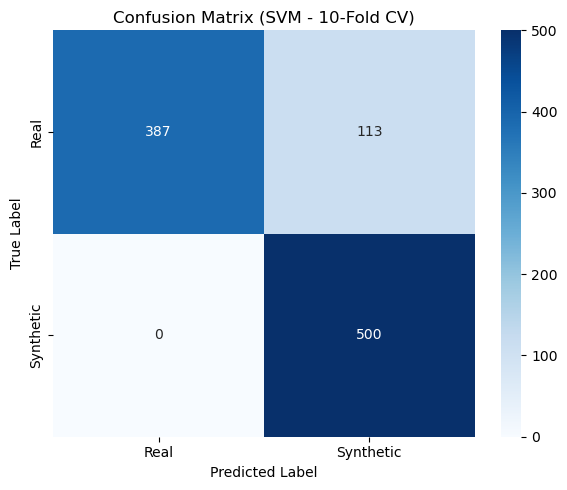

In [34]:
# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# === Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM - 10-Fold CV)')
plt.tight_layout()
plt.show()

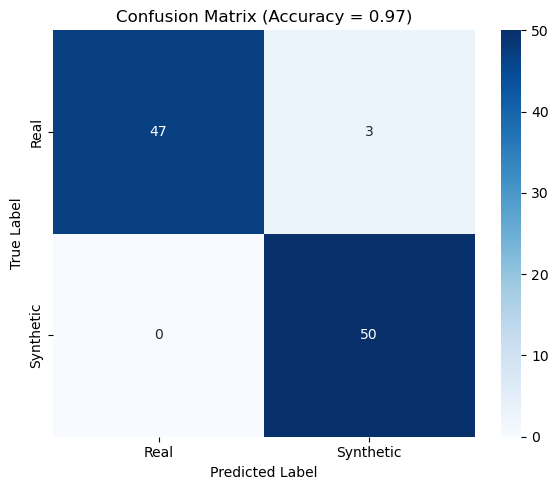

Accuracy:  0.9700
Precision: 0.9434
Recall:    1.0000
F1 Score:  0.9709


In [35]:
# Mixed the Real and the fake data, took 50% of each dataset, and combined them. 

# === Load datasets ===
real_data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')
fake_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_data_AE_SVM.csv')

# === Take 50% from each dataset ===
real_sample = real_data.sample(frac=0.5, random_state=42)
fake_sample = fake_data.sample(frac=0.5, random_state=42)

# === Label the datasets ===
real_sample['label'] = 0  # Real
fake_sample['label'] = 1  # Synthetic

# === Combine datasets ===
combined_data = pd.concat([real_sample, fake_sample], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

# === Split features and labels ===
X = combined_data.drop('label', axis=1)
y = combined_data['label']

# === Standardize features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# === Set up Support Vector Machine Classifier ===
clf = SVC(kernel='rbf', probability=False, random_state=42)
clf.fit(X_train, y_train)

# === Predict ===
y_pred = clf.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# === Display Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Synthetic"],
            yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f})")
plt.tight_layout()
plt.show()

# === Print metrics ===
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")